# HW6 — Deep Neural Networks on MNIST (Starter Notebook) --> Modified for Submission


| **Name:** Xavier Andres Soto Baron | **UCF ID:** 5601517 |


- I filled the starter.

**Instructions**: Complete all cells marked with **TODO**. Do not use high-level wrappers that hide the required implementations. You may use PyTorch modules (`nn`, `optim`, etc.), but implement your own models (FCNN and CNN), training loop, and evaluation.

## What you will build
1. **Data pipeline**: MNIST loaders with train/val/test split (50k/10k/10k), normalization, and train-time augmentation.
2. **Fully Connected NN (Problem 1)**: at least 1 hidden layer + ReLU. Train 5–10 epochs; plot curves.
3. **CNN (Problem 2)**: Conv→BN→ReLU→Pool blocks, data augmentation, train ~10–20 epochs; plot curves; compare.

## Rules
- Use the provided split and transforms.
- Fit/tune on **train+val** pattern: use **validation** to select hyperparams; report **test** once at the end.
- Keep code clean, reproducible, and well-commented.

Hints are provided inline. Good luck!

In [1]:
import math, time, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


## 1) Data: MNIST, normalization, augmentation, and 50k/10k/10k split

- Train-time **augmentation** is modest for MNIST (e.g., small rotations/shifts). Keep augmentations simple.
- **Normalization** uses standard MNIST mean/std: `(0.1307,), (0.3081,)`.
- Split the 60k training set into **50k train** and **10k val**; test is the provided 10k test set.
- Use `shuffle=True` for training loader; `shuffle=False` for val/test.

**You do not need to modify this cell.**

In [2]:
BATCH_SIZE = 64

train_transform = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),  # light aug
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

trainval_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=train_transform)
test_dataset     = datasets.MNIST(root="./data", train=False, download=True, transform=test_transform)

# Make a copy of the val partition that uses NON-augmented transform for fair evaluation on val
trainval_noaug = datasets.MNIST(root="./data", train=True, download=True, transform=test_transform)

train_size, val_size = 50000, 10000
train_subset, val_subset_aug = random_split(trainval_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))
_,              val_subset    = random_split(trainval_noaug,   [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_subset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Train batches:", len(train_loader), " Val batches:", len(val_loader), " Test batches:", len(test_loader))

Train batches: 782  Val batches: 157  Test batches: 157


## 2) Utilities: parameter counting, training/eval skeletons, plotting

- Implement **TODOs** in the training and evaluation loops.
- Keep loops generic so they work for both FCNN and CNN.
- Return epoch-wise history for plotting.

Tips:
- Use `model.train()` and `model.eval()` correctly.
- Use `with torch.no_grad()` during evaluation.
- Compute accuracy by comparing predicted class with ground truth labels.
- Log per-epoch averages (not per-batch) for loss and accuracy.

In [3]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

#Function for training one Epoch
def train_one_epoch(model, loader, optimizer, criterion):
    """TODO: Train for ONE epoch.
    - Put model in train mode
    - For each batch: forward -> compute loss -> backward -> optimizer.step()
    - Track running loss and accuracy; return (avg_loss, avg_acc)
    """
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for inputs, targets in loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * targets.size(0)
        preds = outputs.argmax(dim=1)
        running_correct += (preds == targets).sum().item()
        running_total += targets.size(0)

    avg_loss = running_loss / running_total
    avg_acc = running_correct / running_total
    return avg_loss, avg_acc

# Evaluate the model on a dataloader and return average loss and accuracy
def evaluate(model, loader, criterion):
    """TODO: Evaluate on validation/test.
    - model.eval(); wrap in torch.no_grad()
    - Compute average loss and accuracy over the loader
    """
    model.eval()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * targets.size(0)
            preds = outputs.argmax(dim=1)
            running_correct += (preds == targets).sum().item()
            running_total += targets.size(0)

    avg_loss = running_loss / running_total
    avg_acc = running_correct / running_total
    return avg_loss, avg_acc

def plot_curves(history, title="Training/Validation Curves"):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="train")
    plt.plot(epochs, history["val_loss"],   label="val")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="train")
    plt.plot(epochs, history["val_acc"],   label="val")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy"); plt.legend()
    plt.suptitle(title)
    plt.tight_layout(); plt.show()

def fit(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    """Generic training driver: returns history dict for plotting."""
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    best_val_acc = -1.0
    best_state = None
    for ep in range(1, epochs+1):
        t0 = time.time()
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        va_loss, va_acc = evaluate(model, val_loader,   criterion)
        history["train_loss"].append(tr_loss)
        history["train_acc" ].append(tr_acc)
        history["val_loss"  ].append(va_loss)
        history["val_acc"   ].append(va_acc)
        if va_acc > best_val_acc:
            best_val_acc = va_acc
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        dt = time.time()-t0
        print(f"Epoch {ep:02d}/{epochs} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f} | {dt:.1f}s")
    # Load best on val
    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    return history, best_val_acc

## 3) Problem 1 — Fully Connected Neural Network (FCNN)

- MNIST images are 28×28. Flatten to 784.
- Include **at least 1 hidden layer** with ReLU. Keep it simple (e.g., 128–512 units).
- Output layer size = 10; use cross-entropy loss.

**TODOs**: Define layers in `__init__`, implement `forward`.

Tip: You may add dropout if you like, but it is optional for Problem 1.

In [4]:
class FCNet(nn.Module):
    def __init__(self, hidden_dim=256):
        super().__init__()
        # Simple 2-layer MLP: 784 -> hidden_dim -> 10
        self.fc1 = nn.Linear(28 * 28, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 10)

    #Forward pass function 
    def forward(self, x):
        # x: (batch, 1, 28, 28)
        x = x.view(x.size(0), -1)  # flatten to (batch, 784)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)            # logits for 10 classes
        return x

#Printing message to notify completed TODOS
print("FCNet skeleton ready (fill in TODOs completed).")

FCNet skeleton ready (fill in TODOs completed).


**Train FCNN (Problem 1)**

- Use Adam with lr ~ 1e-3, epochs 5–10.
- Track curves; report **validation accuracy**.
- (Later) evaluate once on **test** after you finish Problem 2 selection.

**TODOs**: Instantiate model, optimizer, criterion, and call `fit`.

FCNet parameters: 203530


C:\Users\Xavie\AppData\Local\Programs\Python\Python314\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01/6 | train loss 0.3654 acc 0.8875 | val loss 0.1268 acc 0.9598 | 19.8s
Epoch 02/6 | train loss 0.1610 acc 0.9505 | val loss 0.1105 acc 0.9679 | 19.4s
Epoch 03/6 | train loss 0.1247 acc 0.9610 | val loss 0.0775 acc 0.9754 | 19.2s
Epoch 04/6 | train loss 0.1100 acc 0.9659 | val loss 0.0764 acc 0.9747 | 17.7s
Epoch 05/6 | train loss 0.0998 acc 0.9686 | val loss 0.0723 acc 0.9787 | 17.2s
Epoch 06/6 | train loss 0.0944 acc 0.9715 | val loss 0.0672 acc 0.9786 | 17.0s
Best Fully Connected Neural Network validation accuracy: 0.9787


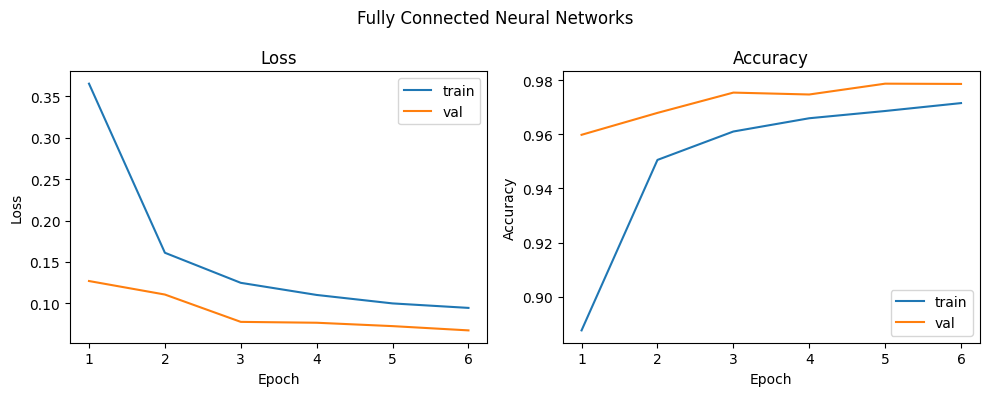

In [5]:
# Build Fully connecte network, optimizer, and loss
model_fc = FCNet(hidden_dim=256).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_fc = optim.Adam(model_fc.parameters(), lr=1e-3)

#Printing out the parameters
print("FCNet parameters:", count_params(model_fc))

# Train and validate FCNet
fc_epochs = 6 #using 6 (5,10)
history_fc, best_val_acc_fc = fit(
    model_fc, train_loader, val_loader,
    optimizer_fc, criterion,
    epochs=fc_epochs
)

#Printing out validation
print(f"Best Fully Connected Neural Network validation accuracy: {best_val_acc_fc:.4f}")

# Plot curves
plot_curves(history_fc, title="Fully Connected Neural Networks")


## 4) Problem 2 — Convolutional Neural Network (CNN)

Architecture requirements:
- At least **two** Conv→ReLU blocks (add **BatchNorm** after conv is recommended).
- **Pooling** (e.g., MaxPool) to reduce spatial size.
- Fully connected head → 10 classes.
- Use the same normalization; train-time **augmentation** already applied in the data loader.

**TODOs**: Define layers in `__init__`, implement `forward`.

Tip: A small, effective starting point is: `Conv(1→32, 3×3) → BN → ReLU → Conv(32→64, 3×3) → BN → ReLU → MaxPool`, then flatten and use a small MLP head (e.g., 128→10). Adjust as needed. Keep it lightweight, MNIST is simple.


In [6]:
#Starting the Convolutional Neural Networks and the forward passes
class CNNNet(nn.Module):
    #Initializing the Convolutional Neural Network
    def __init__(self):
        super().__init__()
        # Block 1: 1 -> 32
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)

        # Block 2: 32 -> 64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)

        # Pooling
        self.pool = nn.MaxPool2d(2, 2)  # 28x28 -> 14x14

        # Fully connected head
        # After convs + single pool: feature map size is 64 x 14 x 14
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    #Forward pass function
    def forward(self, x):
        # x: (batch, 1, 28, 28)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.pool(x)  # reduce spatial dimension

        x = x.view(x.size(0), -1)  # flatten
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)  # logits
        return x

#Message to confirm Convolutional Neural Network was completed
print("CNN skeleton ready (fill in TODOs).")

CNN skeleton ready (fill in TODOs).


**Train CNN (Problem 2)**

- Use Adam with lr ~ 1e-3, epochs ~10–20.
- Data augmentation is already applied to the training set (Affine).
- Plot curves; report **validation accuracy** and compare to FCNN.

**TODOs**: Instantiate model, optimizer, criterion, and call `fit`.

Note: MNIST CNNs commonly achieve **>98%** val accuracy; if not, check learning rate, architecture, or training length.

CNNNet parameters: 1626058
Epoch 01/11 | train loss 0.2292 acc 0.9316 | val loss 0.0629 acc 0.9803 | 53.0s
Epoch 02/11 | train loss 0.0891 acc 0.9719 | val loss 0.0579 acc 0.9818 | 51.6s
Epoch 03/11 | train loss 0.0738 acc 0.9770 | val loss 0.0444 acc 0.9870 | 51.8s
Epoch 04/11 | train loss 0.0622 acc 0.9814 | val loss 0.0389 acc 0.9876 | 51.0s
Epoch 05/11 | train loss 0.0579 acc 0.9819 | val loss 0.0341 acc 0.9895 | 51.2s
Epoch 06/11 | train loss 0.0532 acc 0.9829 | val loss 0.0383 acc 0.9879 | 51.2s
Epoch 07/11 | train loss 0.0478 acc 0.9854 | val loss 0.0461 acc 0.9854 | 51.4s
Epoch 08/11 | train loss 0.0445 acc 0.9862 | val loss 0.0363 acc 0.9894 | 51.0s
Epoch 09/11 | train loss 0.0426 acc 0.9867 | val loss 0.0270 acc 0.9915 | 51.2s
Epoch 10/11 | train loss 0.0383 acc 0.9882 | val loss 0.0276 acc 0.9911 | 50.9s
Epoch 11/11 | train loss 0.0362 acc 0.9886 | val loss 0.0284 acc 0.9913 | 51.1s
Best Convolutional Neural Network validation accuracy: 0.9915


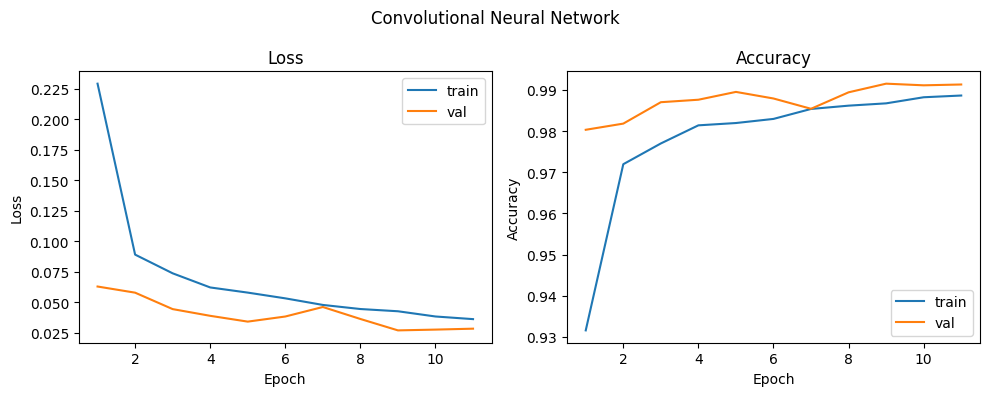

In [7]:
# Build CNN, optimizer, and loss
model_cnn = CNNNet().to(device)
criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=1e-3)

#Printing parameters
print("CNNNet parameters:", count_params(model_cnn))

# Train and validate CNN
cnn_epochs = 11  #Using 11 --> (10,20)
history_cnn, best_val_acc_cnn = fit(
    model_cnn, train_loader, val_loader,
    optimizer_cnn, criterion_cnn,
    epochs=cnn_epochs
)

print(f"Best Convolutional Neural Network validation accuracy: {best_val_acc_cnn:.4f}")

# Plot curves
plot_curves(history_cnn, title="Convolutional Neural Network")


## 5) Final test evaluation (after selecting your best model)

- Once you’ve tuned hyperparameters on **validation**, pick your best model configuration.
- Evaluate once on the **test set** and record accuracy.
- Report final numbers and compare **parameter counts** between FCNN and CNN.

**TODOs**: Call `evaluate` on `test_loader` with your best model.

Note: If you want to train on **train+val** for a final test-only run (optional), you will need to rebuild a loader with the combined dataset and re-train briefly. Keep this consistent with the assignment instructions.

In [8]:
# Decide which model is better on validation
#Final Test Evaluation --> Chechk which model is the best
print(f"Fully Connected Neural Network best validation accuracy:  {best_val_acc_fc:.4f}")
print(f"Convolutional Neural Network best validation accuracy: {best_val_acc_cnn:.4f}")

#Check which model is the best
if best_val_acc_cnn >= best_val_acc_fc: #When CNN is better
    best_model_name = "Convolutional Neural Network"
    best_model = model_cnn
    best_criterion = criterion_cnn
else: #When FCNet is better
    best_model_name = "Fully Connected Neural Network"
    best_model = model_fc
    best_criterion = criterion  # from FCNet cell

# Evaluate chosen model on test set ONCE
test_loss, test_acc = evaluate(best_model, test_loader, best_criterion)

#Printing the best model
print(f"The Best model is: {best_model_name}")
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

Fully Connected Neural Network best validation accuracy:  0.9787
Convolutional Neural Network best validation accuracy: 0.9915
The Best model is: Convolutional Neural Network
Test loss: 0.0231, Test accuracy: 0.9923


## 6) Report / Discussion (inline)

Please include in your notebook:
- FCNN and CNN **loss/accuracy curves**.
- Final **validation** accuracy for both; and **test** accuracy once for your best model.
- **Parameter counts** for both models (use `count_params`).
- A short discussion comparing FCNN vs CNN: accuracy, generalization, training behavior, and parameter efficiency.


### Summary of Results
- **Fully Connected Neural Network (FCNN)**
  - Parameters: **203,530**
  - Best validation accuracy: **0.9787**

- **Convolutional Neural Network (CNN)**
  - Parameters: **1,626,858**
  - Best validation accuracy: **0.9915**
  - Final test accuracy (best model): **0.9923**
  - Final test loss: **0.0231**

Both loss/accuracy curves for FCNN and CNN (shown above) indicate stable training and good generalization.


### Comparison: FCNN vs CNN

**1. Accuracy & Generalization**
- The **CNN significantly outperforms** the FCNN, achieving higher validation and test accuracy.
- CNN validation accuracy reaches **0.9915**, while the FCNN plateaus at **0.9787**.
- CNN generalizes better due to its ability to capture spatial structure in images.

**2. Training Behavior**
- Both models show smooth loss decrease, but the CNN converges faster and more consistently.
- The validation curve for CNN closely follows the training curve, indicating minimal overfitting.
- FCNN shows slightly more gap between training/validation, reflecting weaker feature extraction.

**3. Parameter Efficiency**
- FCNN: ~203k parameters  
- CNN: ~1.63M parameters  
Despite having **more parameters**, the CNN uses them much more effectively:
  - Convolutions share weights across spatial positions.
  - Filters learn reusable patterns (edges, shapes) across the image.
  - FCNN treats the image as a flat vector, losing spatial information and requiring more learning from scratch.

**4. Explanation of performance**
- MNIST digits contain clear spatial patterns (curves, edges, strokes).
- CNNs exploit locality, translation invariance, and hierarchical feature learning.
- FCNNs cannot leverage structure and therefore underperform on image data.


### Conclusion
The **Convolutional Neural Network** is the best model for MNIST in this homework.  
It achieves the highest validation accuracy (**0.9915**) and strong test accuracy (**0.9923**), outperforming the FCNN in every aspect: accuracy, generalization, stability, and feature extraction.  
These results confirm why CNNs are the standard architecture for image recognition tasks.
